In [1]:
from IPython.display import HTML
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
writer = SummaryWriter('./dcgan_loss')

# путь до изображений
image_path = './archive/img_align_celeba/'

# Количество воркеров для сборки датасета
workers = 2

# Количество каналов цвета
nc = 3

# размер изображения (пока попробуем на изображениях 64 * 64, так как для них обучение GAN существенно быстрее)
image_size = 64

# Рамер карты признаков для генератора
ngf = 64

# Рамер карты признаков для дискриминатора
ndf = 64

# размер батча
batch_size = 350

# размер латентного вектора
z_dim = 100

# Количество эпох
epochs_num = 5

# Шаг
lr = 0.0002
lr_g = lr
lr_d = lr * 0.2

# Параметр для оптимизатора Adam
beta1 = 0.5

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Active device: {device}")

Active device: cuda:0


In [4]:
dataset = datasets.ImageFolder(
    root=image_path,
    transform=transforms.Compose(
        [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

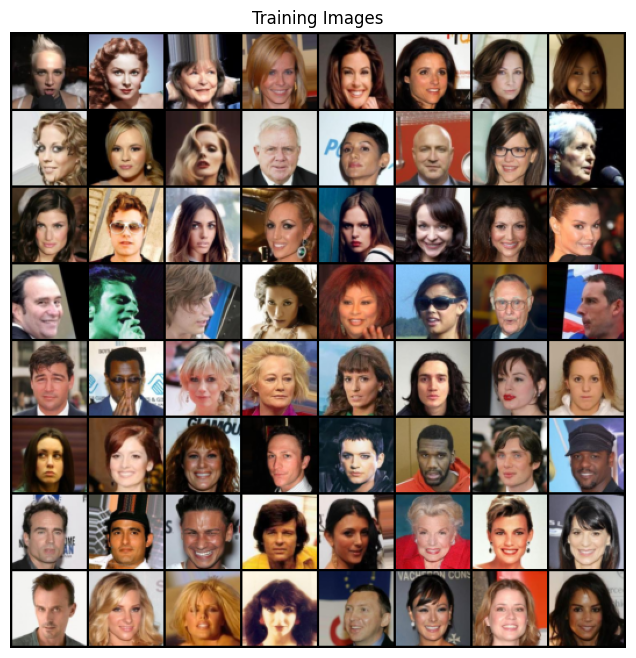

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:image_size], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

Реализуем CSP блок по следующей схеме.

<p align="center">
  <img src="./csp_up.jpg" width="500"/>
</p>

In [6]:
class CSPBlock(nn.Module):
    def __init__(self, in_channels):
        super(CSPBlock, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Conv2d(in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=3, stride=1, padding=1, bias=False)
        )

        self.seq2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=4, stride=2, padding=1, bias=False)
        )

    def forward(self, x):
        x1, x2 = torch.split(x, x.shape[1] // 2, dim=1)
        x1 = self.seq1(x1)
        x2 = self.seq2(x2)

        return x1 + x2

Реализуем генератор по следующей схеме.

<p align="center">
  <img src="./generator.jpg" width="500"/>
</p>

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim, out_channels=ngf * 16, kernel_size=4, stride=1, padding=0, bias=False),
            CSPBlock(in_channels=ngf * 16),
            CSPBlock(in_channels=ngf * 8),
            CSPBlock(in_channels=ngf * 4),
            CSPBlock(in_channels=ngf * 2),
            # CSPBlock(in_channels=ngf), закомментируем, чтобы был выход (batch_size, number_of_channels, 64, 64), а не (batch_size, number_of_channels, 128, 128)
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# кастомная инициализация весов netG или netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Инициализируем генератор
netG = Generator(z_dim=z_dim).to(device)

# Инициализируем веса
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): CSPBlock(
      (seq1): Sequential(
        (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): ReLU(inplace=True)
        (5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (seq2): Sequential(
        (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      )
    )
    (2): CSPBlock(
      (seq1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

In [11]:
# Дискриминатор из ноутбука 

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# инициализируем дискриминатор
netD = Discriminator().to(device)

# Инициализируем веса
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [13]:
# Инициализируем лосс
criterion = nn.BCELoss()

# Создаем батч с рандомным шумом для генерации
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Метки для реальных данных и фековых
real_label = 1.
fake_label = 0.

# Устанавливаем оптимизаторы для G и D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Попробуем обучить на 5 эпохах.

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# Для каждой эпохи
for epoch in range(epochs_num):
    # Для каждого батча
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Учим дискриминатор: максимизируем log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Для батча
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Прямой прогон батча из реальных картинок D
        output = netD(real_cpu).view(-1)
        # Считаем лосс на всем батче реальных картинок
        errD_real = criterion(output, label)
        # Вычисляем градиенты для дискриминатора
        errD_real.backward()
        D_x = output.mean().item()

        ## Учим на полном фейковом батче
        # Генерируем бат латентных векторов
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Генерируем фековый батч с помощью G
        fake = netG(noise)
        label.fill_(fake_label)
        # Классифицируем фековый батч с помощью D
        output = netD(fake.detach()).view(-1)
        # Вычисляем лосс дискриминатора на фейковом батче
        errD_fake = criterion(output, label)
        # Вычисляем градиент для фейкового батча, он суммируется с предидущим
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Вычисляем ошибку на реальном и фековом батчах
        errD = errD_real + errD_fake
        # Обновляем веса D
        optimizerD.step()

        ############################
        # (2) Учим генератор: максимизируем log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # для генератора фейковые метки есть реальные (0 меняем на 1)
        # Так как мы обновили веса дискриминатора прогоним фековый батч через него еще  раз
        output = netD(fake).view(-1)
        # Вычислим лосс G основываясь на выходе D
        errG = criterion(output, label)
        # Вычислим градиент для G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Обновляем веса G
        optimizerG.step()

        # Выводим статистику обучения
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs_num, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Сохраним лоссы
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        writer.add_scalar('generator loss', errG.item(), iters)
        writer.add_scalar('discriminator loss', errD.item(), iters)

        # Проверим какие картинки рисует генератор
        if (iters % 500 == 0) or ((epoch == epochs_num-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


writer.flush()

Starting Training Loop...


[0/5][0/579]	Loss_D: 2.2017	Loss_G: 1.5165	D(x): 0.3430	D(G(z)): 0.5318 / 0.2836
[0/5][50/579]	Loss_D: 0.0322	Loss_G: 18.5212	D(x): 0.9805	D(G(z)): 0.0000 / 0.0000
[0/5][100/579]	Loss_D: 0.0007	Loss_G: 47.8093	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[0/5][150/579]	Loss_D: 0.0017	Loss_G: 47.5499	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000
[0/5][200/579]	Loss_D: 0.0011	Loss_G: 47.4641	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[0/5][250/579]	Loss_D: 0.0015	Loss_G: 47.4051	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000
[0/5][300/579]	Loss_D: 0.0014	Loss_G: 47.3084	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000
[0/5][350/579]	Loss_D: 0.0000	Loss_G: 47.3600	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][400/579]	Loss_D: 0.0000	Loss_G: 47.2639	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][450/579]	Loss_D: 0.0000	Loss_G: 47.1859	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][500/579]	Loss_D: 0.0000	Loss_G: 47.2298	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][550/579]	Loss_D: 0.0000	Loss_G: 47.1384	D(x): 1.0000	D(G(z)): 0.0000 / 0.0

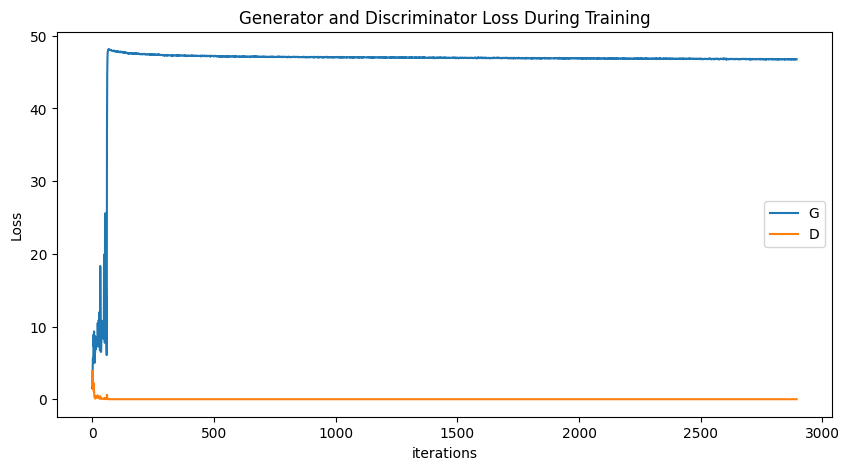

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

На иллюстрации видно отсутствие сходимости Генератора. Посмотрим на сгенерированные изображения.

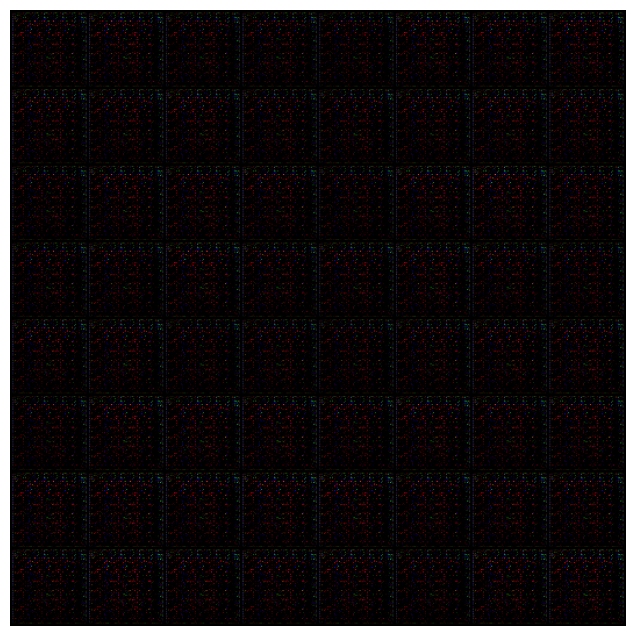

In [16]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

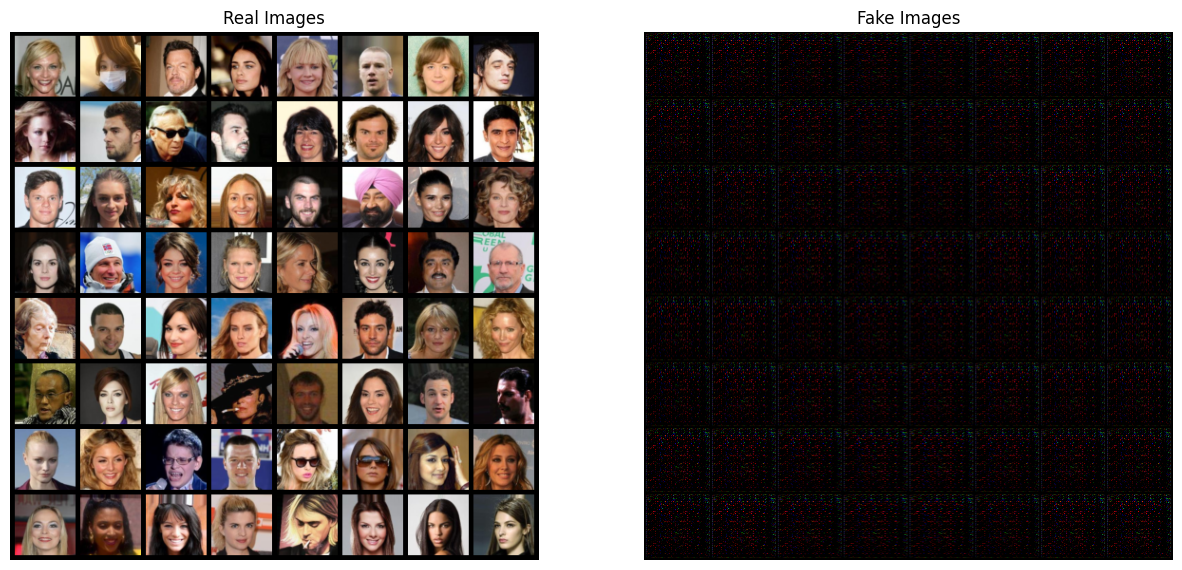

: 

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Сгенерирован шум, будем улучшать GAN.